# **COGS 108 Final Project** - 2018 Trending YouTube Video Analysis

# **Data Cleaning/Pre-processing**

In [1]:
# Importing Libraries

# Data Objects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import json
import datetime
from collections import Counter

# Significance Test
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# NLP
import re
import nltk
from nltk.corpus import stopwords

In [2]:
# Read in datasets
df = pd.read_csv("./Datasets/USvideos.csv")

# Check the data
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


Initial Column Observations: 
- **video_id**: contains alphanumeric code for video identification. However, this is not helpful for our data exploration/analysis
- **trending_date**: contains the date the video started trending in YYDDMM format
- **title**: contains the title of the video.  Some contain non-ascii characters and emojis which we will need to remove
- **channel_title**: contains the title of the channel
- **category_id**: contains the id number for each category.  We will need to match the id number to its corresponding category name
- **publish_time**: contains the date and time the video was published.  It is formatted differently from trending date, which we plan to clean
- **tags**: contains the tags in one long string, which we will need to separate into a list
- **views**, **likes**, **dislikes**, **comment_count**: contains numerical values
- **thumbnail_link**: contains url for picture of the thumbnail. 
- **comments_disabled**, **ratings_disabled**, **video_error_or_removed**: contains boolean values
- **description**: contains the video description as a string.  Some contain non-ascii characters, emojis, and urls which we will need to remove if we use

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


We have 40,049 entries in this dataset, and all the columns in the dataset have some value with the exception of the description column which has 570 (about 1.3%) null values.  This is expected since users aren't required to include a description of their videos.

### **Remove "video id" and "thumbnail link" columns**
Each YouTube video has a **video_id**, which is a unique alphanumeric code.  Each YouTube video also includes a thumbnail that is shown with their video.  The link to the video thumbnails are contained in the **thumbnail_link** column.  We will not be exploring the video id's as it's simply a way for YouTube to easily differentiate videos.  And although it would be interesting to explore thumbnails, as it may be that users are more likely to view a video for certain types of thumbnails, we will believe that would be a separate project one could explore.

In [4]:
df.drop(columns=['video_id','thumbnail_link'], inplace=True, errors='ignore')
df.head(n=2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John..."


### **Category ID mapping**
Currently, the **category_id** column contains the category id of each video, which is in the form of a number. We will replace the category id with the corresponding category title, as provided to us from in a json file from the original Kaggle dataset.  To do this, we will create the dictionary **categoryID**, which will contain each category's information (i.e. kind, etag, id, title, etc.)  We are only interested in the id and title, so we will create a separate dictionary called **ID_to_Category** which will just contain the id's as keys and the corresponding titles.

In [5]:
with open("./Datasets/US_category_id.json") as f: categoryID = json.load(f)
categoryID, l_c = categoryID['items'], len(categoryID['items'])
ID_to_Category = dict(zip([int(categoryID[i]['id']) for i in range(l_c)],
                          [categoryID[i]['snippet']['title'] for i in range(l_c)]))

In [6]:
ID_to_Category

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [7]:
ID_to_Category.keys()

dict_keys([1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [8]:
# Saving the dictionary as a JSON file for further use in analysis
with open('Datasets/id_to_categori.json', 'w') as outfile:
    json.dump(ID_to_Category, outfile)

Now we will replace the id numbers with their corresponding category titles in the category id column.

In [9]:
df['category_id'] = df['category_id'].apply(lambda x: ID_to_Category[x])
df.head(n=2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John..."


### **Date Instancing**
Both the **trending_date** and **publish_time** columns include dates, but in different formattings. Publish_time includes the time of publication and the date, while trending_date only includes the date.  Since we don't have the time the video started trending, we cannot compare it to the publish time. In the end, we will clean the data such that both columns include datetime.date objects.

In [10]:
def clean_trending_date(date):
    y,d,m = date.split('.')
    return datetime.date(int(y)+2000,int(m),int(d))

def clean_publish_time(time):
    y,m,d = time.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

In [11]:
df['trending_date'] = df['trending_date'].apply(clean_trending_date)
df['publish_time'] = df['publish_time'].apply(clean_publish_time)

In [12]:
df.head(n=2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13,SHANtell martin,748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John..."


### **Tag Splitting**
We will clean up the **tags** column by separating tags into a list instead of one long string.

In [13]:
def clean_tags(tag):
    if tag == '[none]': return []
    return tag.lower().replace('"','').split('|')

In [14]:
df['tags'] = df['tags'].apply(clean_tags)
df.head(n=2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13,[shantell martin],748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13,"[last week tonight trump presidency, last week...",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John..."


### **Natural Language Processing for Title**
We developed a function to clean the **video titles** by removing stop words, non-alphanumeric tokens, and money amounts to better understand the occurance of certain keywords being used in the titles. 

In [15]:
def clean_titles(title):
    tokens = title.lower().split()
    cleaned = []
    sw = set(stopwords.words('english'))
    for token in tokens:
        if token.startswith('$') or token.isnumeric() or not token.isalnum() or token in sw:  # Remove money amount, non-alphanumeric tokens, or stopwords
            continue
        else:
            cleaned.append(token)
    return ' '.join(cleaned)

df['title_cl'] = df['title'].apply(clean_titles)

In [16]:
# Check to see that clean title column was added
df.head(n=2)

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description,title_cl
0,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,2017-11-13,[shantell martin],748374,57527,2966,15954,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,want talk marriage
1,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,2017-11-13,"[last week tonight trump presidency, last week...",2418783,97185,6146,12703,False,False,False,"One year after the presidential election, John...",trump last week tonight john oliver


# **Data Visualization**
### **Title Word Choice**
Now that we have successfully cleaned our data, we will start exploring our data.  We will start by looking at what words are commonly used in video titles, as we predicted that word choice will be an important factor for Trending videos.

In [17]:
# from collections, a Counter object
cnt = Counter()

# Finding the occurence of words in video titles
for title in df['title_cl']:
    for token in title.split():
        cnt[token] += 1

# Finding the 50 most used words in video titles
dist = cnt.most_common(50)
top_words = []
freqs = []
for word, freq in dist:
    top_words.append(word)
    freqs.append(freq)

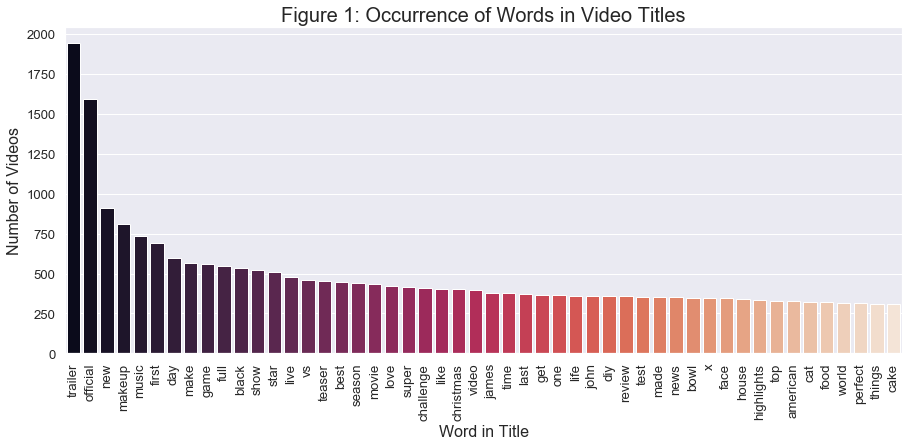

In [19]:
# Graphing occurrence of words in title
fig= plt.figure(figsize=(15,6))
plt.xticks(rotation=90)
sns.barplot(top_words, freqs, palette="rocket")
sns.set_style("darkgrid")
sns.set(font_scale=1.2)
plt.xlabel('Word in Title', fontsize=16)
plt.ylabel('Number of Videos', fontsize=16)
plt.title('Figure 1: Occurrence of Words in Video Titles', fontsize=20)
plt.show()

From Figure 1, we can see that the top three words are **trailer**, **official**, and **new**, with "trailer" and "official" having a number of more occurences than other words.  This is interesting as these two words seem to go together, such as a video titled "official trailer".

### **Video Categories**
Now we will explore what type of trending videos are most and least common by looking at the frequencies of video categories.

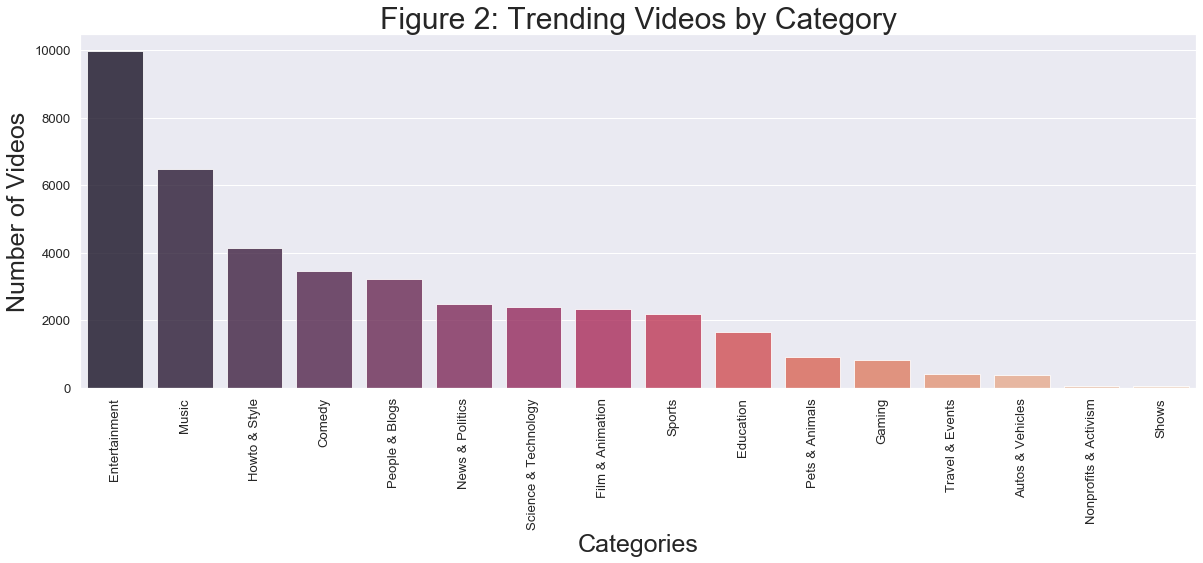

In [20]:
categories = df['category_id'].value_counts()

# Bar graph for number of videos per category
plt.figure(figsize=(20,6.5))
sns.barplot(categories.index, categories.values, alpha=0.8, palette="rocket")
sns.set_style("darkgrid")
sns.set(font_scale=1.6)
plt.xticks(rotation=90)
plt.xlabel('Categories', fontsize=25)
plt.ylabel('Number of Videos', fontsize=25)
plt.title('Figure 2: Trending Videos by Category', fontsize=30)
plt.show()

From Figure 2, we can see that the Entertainment category has the most number of trending videos with about 10,000, which accounts for about a quarter of the videos in this dataset.  Meanwhile, more than half of the other categories seem to have video counts below 3,000. Looking at Figure 1 and 2 together, we observed that certain keywords like "trailer" are related to popular categories of videos such as "Entertianment". 

In [21]:
# Caculating the percentages for top 3 categories
entertainment = df[df['category_id'] == 'Entertainment']['category_id'].count() / df['category_id'].count() * 100
music = df[df['category_id'] == 'Music']['category_id'].count() / df['category_id'].count() * 100
howto = df[df['category_id'] == 'Howto & Style']['category_id'].count() / df['category_id'].count() * 100

# Calculating the percentages for bottom 3 categories
autos = df[df['category_id'] == 'Autos & Vehicles']['category_id'].count() / df['category_id'].count() * 100
shows = df[df['category_id'] == 'Shows']['category_id'].count() / df['category_id'].count() * 100
nonprofits = df[df['category_id'] == 'Nonprofits & Activism']['category_id'].count() / df['category_id'].count() * 100

After doing some calculations for the percentages of categories, it is noteworthy that **Entertainment** (24.3%), **Music** (15.8%), and **Howto & Style** (10.1%) make up half of the trending videos.  The commonalities between these videos are that they are predominantly leisure type of videos.  They seem to be more personable and fun as opposed to more serious types of categories, such as Autos & Vehicles and Nonprofits & Activism, which don't have nearly as many videos on trending.

### **Channel Frequencies**
Now we will explore which channels have a large number of trending videos.  Based off our exploration of categories, we assume that the channels with the most number of trending videos will be Entertainment, Music, or Howto & Style channels.  We will start off by calculating the trending video frequency for each channel.

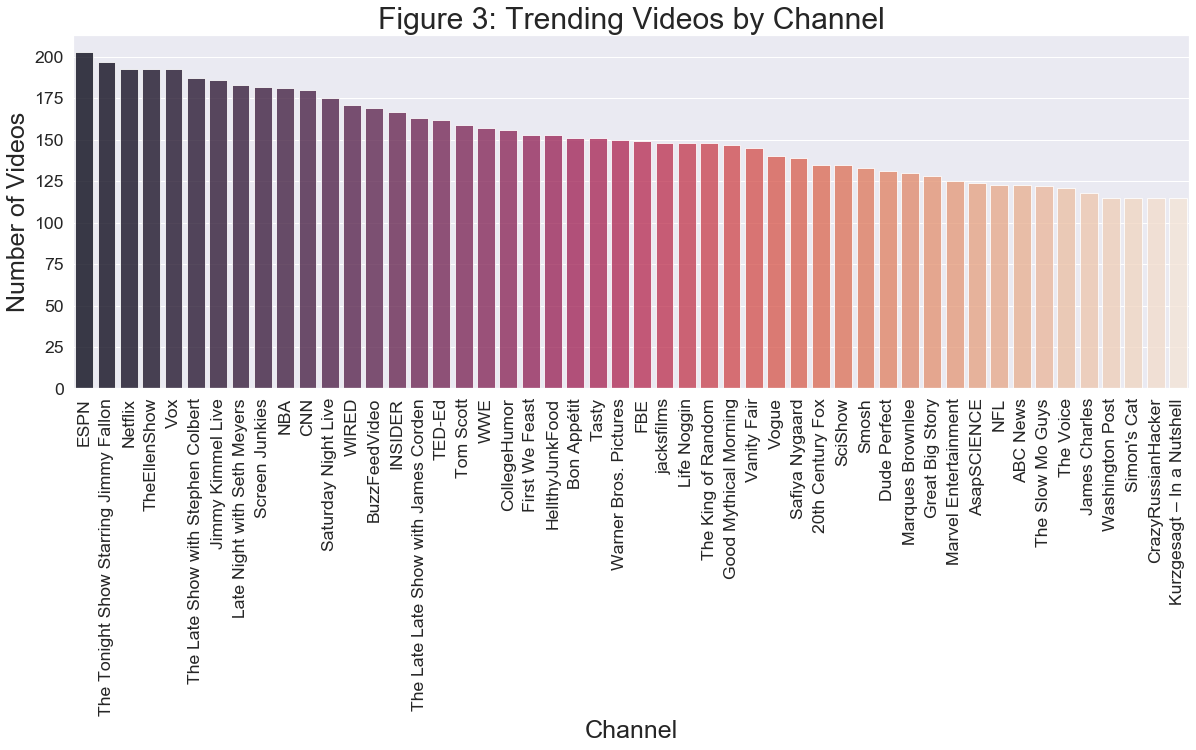

In [22]:
channel_freq = df['channel_title'].value_counts()
# Isolating the top 50 channels
channel_freq = channel_freq[0:50]
# Bar graph for number of videos for the top 50 channels
plt.figure(figsize=(20,6.5))
sns.barplot(channel_freq.index, channel_freq.values, alpha=0.8, palette="rocket")
sns.set_style("darkgrid")
sns.set(font_scale=1.4)
plt.xticks(rotation=90)
plt.xlabel('Channel', fontsize=25)
plt.ylabel('Number of Videos', fontsize=25)
plt.title('Figure 3: Trending Videos by Channel', fontsize=30)
plt.show()

From, we can see that **ESPN** (203 videos), **The Tonight Show Starring Jimmy Fallon** (197 videos), and **Vox** / **TheEllenShow** / **Netflix** (193 videos) are the top 3 channels with Trending videos. Here is a list of the top 10 channels with trending videos and their respective categories.
- ESPN: Sports
- The Tonight Show Starring Jimmy Fallon: Comedy
- Vox: News & Politics
- TheEllenShow: Entertainment
- Netflix: Entertainment
- The Late Show with Stephen Colbert: Entertainment
- Jimmy Kimmel Live: Entertainment
- Late Night with Seth Meyers: Comedy
- Screen Junkies: Film & Animation
- NBA: Sports

In [23]:
channel_freq[0:10]

ESPN                                      203
The Tonight Show Starring Jimmy Fallon    197
Netflix                                   193
TheEllenShow                              193
Vox                                       193
The Late Show with Stephen Colbert        187
Jimmy Kimmel Live                         186
Late Night with Seth Meyers               183
Screen Junkies                            182
NBA                                       181
Name: channel_title, dtype: int64

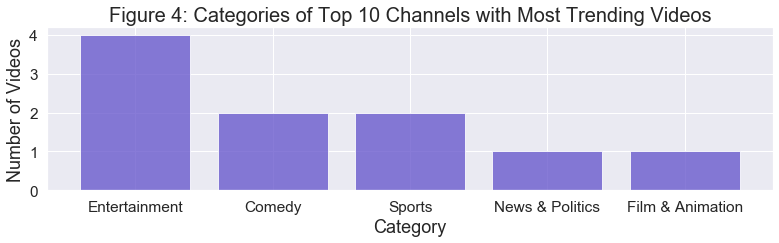

In [24]:
d = {'Entertainment': 4, 'Comedy': 2, 'Sports': 2, 'News & Politics': 1, 'Film & Animation': 1}

# Bar graph for the number of videos per category for the top 10 channels with trending videos
plt.figure(figsize=(13,3))
plt.bar(range(len(d)), list(d.values()), align='center', alpha=0.8, 
        color="slateblue")
plt.xticks(range(len(d)), list(d.keys()))
plt.xlabel("Category", fontsize=18)
plt.ylabel("Number of Videos",fontsize=18)
plt.title('Figure 4: Categories of Top 10 Channels with Most Trending Videos', 
          fontsize=20)
plt.show()

Our earlier exploration of the categories supports the fact that almost half of the channels in the top 10 are Entertainment channels.  However, the other top video categories (Music and Howto & Style) are not created by the top 10 channels in favor for Comedy (4th top category), Sports (9th), News & Politics (6th), and Film & Animation (8th) videos.  We will visualize the channel frequencies as a histogram to further investigate.

Text(0.5, 1.0, 'Figure 5: Frequency of Channels with Trending Videos')

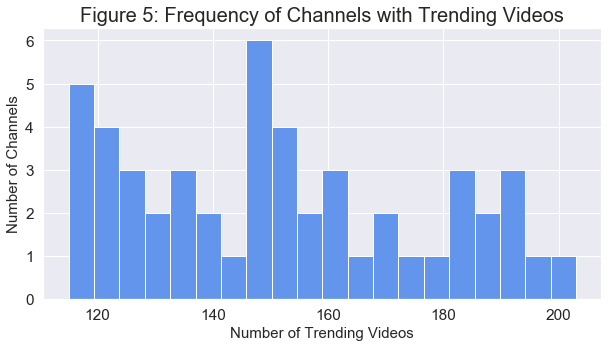

In [25]:
# Histogram for channel frequencies
plt.figure(figsize=(10,5))
channel_freq.hist(bins=20, color="cornflowerblue")
plt.xlabel("Number of Trending Videos", fontsize=15)
plt.ylabel("Number of Channels", fontsize=15)
plt.title('Figure 5: Frequency of Channels with Trending Videos', fontsize=20)

This histogram, Figure 5, helps us understand why the top 10 channels with trending videos may not coincide with the exploration of categories we did earlier as the distribution is extremely right skewed.  Around 1350 channels have under 10 trending videos, while we have few channels with over 100 trending videos.  This tells us that looking too deeply into the top 10 channels won't really help us as the majority have well below that number of trending videos.  We will calculate the percentages of the number of trending videos that channels have to look at the distribution more closely.

In [26]:
# Percentage of number of trending videos a channel has
above_20 = len([i for i in channel_freq if i > 20]) / len(channel_freq) * 100
percent_16_20 = len([i for i in channel_freq if (i <= 20) & (i > 15)]) / len(channel_freq) * 100
percent_11_15 = len([i for i in channel_freq if (i <= 15) & (i > 10)]) / len(channel_freq) * 100
percent_6_10 = len([i for i in channel_freq if (i <= 10) & (i > 5)]) / len(channel_freq) * 100
percent_1_5 = len([i for i in channel_freq if (i <= 5)]) / len(channel_freq) * 100

Percentage of Number of Trending Videos A Channel has:
- 1-5 videos: 34.3%
- 6-10 videos: 24.9%
- 11-15 videos: 10.7%
- 16-20 videos: 7.0%
- 20+ videos: 22.8%

This demonstrates that more than 3/4 of channels have created under 20 trending videos, with 34% of channels having between 1-5 trending videos.  This shows us that the top channels with well over 100 trending videos are outliers.

Text(0.5, 1.0, 'Figure 6: Channels with Less than 20 Trending Videos')

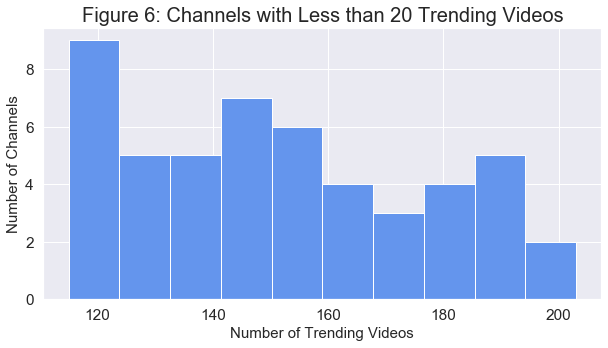

In [27]:
# Histogram for number of channels vs number of trending videos below 20
plt.figure(figsize=(10,5))
channel_freq[-1704:].hist(bins=10, color='cornflowerblue')
plt.xlabel("Number of Trending Videos", fontsize=15)
plt.ylabel("Number of Channels", fontsize=15)
plt.title("Figure 6: Channels with Less than 20 Trending Videos", fontsize=20)

### **Exploration of Views**

In [28]:
df.describe()

,views,likes,dislikes,comment_count
count,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


- **Average number of views**: 2,360,784
- **Median number of views**: 681,861
- With the average being so much larger than the median, this tells us that the distribution of views is strongly skewed to the right.

Text(0.5, 1.0, 'Figure 7: Views of Trending Videos')

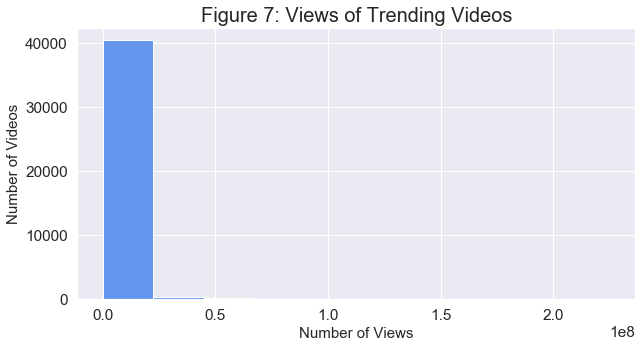

In [29]:
# Histogram of the views data for all the videos
plt.figure(figsize=(10,5))
v1 = df['views'].hist(color='cornflowerblue')
plt.xlabel('Number of Views', fontsize=15)
plt.ylabel('Number of Videos', fontsize=15)
plt.title('Figure 7: Views of Trending Videos', fontsize=20)

Figure 7 that the distribution is very right skewed and shows us that the majority of videos have views under 5 million. We will plot another histogram to look at the distribution a little bit closer.

Text(0.5, 1.0, 'Figure 8: Videos with Fewer than 5 Million Views ')

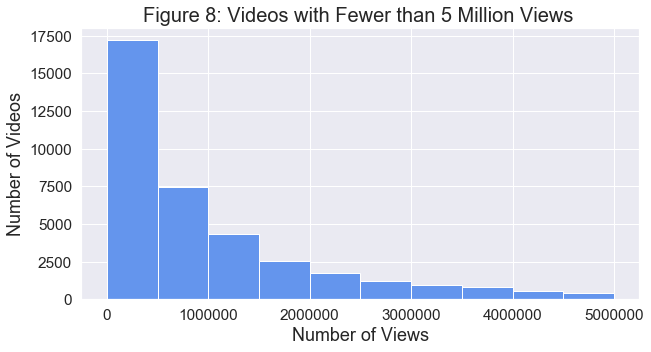

In [30]:
# Subset of views below 5 million
v5million = df[df['views'] < 5e6]['views']

# Histogram of the views data for videos with views below 5 million
plt.figure(figsize=(10,5))
v2 = v5million.hist(color='cornflowerblue')
plt.xlabel('Number of Views', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 8: Videos with Fewer than 5 Million Views ', fontsize=20)

Now it is easy to see that the majority of videos have under 1 million views.  We will calculate the exact percentage below.

In [31]:
views_2 = df[df['views'] < 2e6]['views'].count() / df['views'].count() * 100
views_1 = df[df['views'] < 1e6]['views'].count() / df['views'].count() * 100

print("% videos with under 2 million views: ", views_2)
print("% videos with under 1 million views: ", views_1)

% videos with under 2 million views:  76.9811228601431
% videos with under 1 million views:  60.09426359618062


### **Exploration of Likes**
- **Average number of likes**: 74,266
- **Median number of likes**: 18,091

This tells us that the distribution of views is strongly skewed to the right, with the majority of videos having below 18,000 likes. To visualize the data we will create a histogram of the like data for all the videos.

Text(0.5, 1.0, 'Figure 9: Total Likes for Trending Videos')

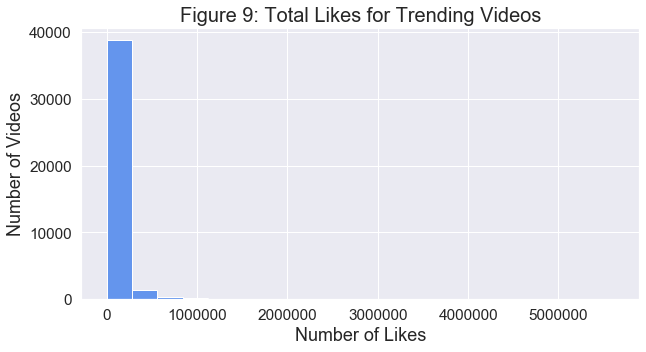

In [32]:
# Histogram of the likes data for all the videos
plt.figure(figsize=(10,5))
l1 = df['likes'].hist(bins=20, color='cornflowerblue')
plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 9: Total Likes for Trending Videos', fontsize=20)

Figure 9 confirms that the distribution skewed to the right and shows us that the majority of videos have under 500,000 likes. We will plot another histogram for videos with likes below 20,000 as this seems to be the amount that most trending videos have.

Text(0.5, 1.0, 'Figure 10: Total Likes for Trending Videos Below 20,000 Likes ')

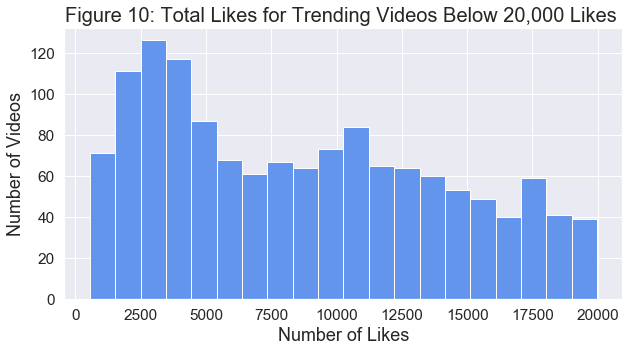

In [33]:
# Subset of likes below 20,000
below20000 = df[df['views'] < 2e4]['views']
plt.figure(figsize=(10,5))
# Histogram of the likes data for videos with likes below 20 thousand
l2 = below20000.hist(bins=20,color='cornflowerblue')
plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 10: Total Likes for Trending Videos Below 20,000 Likes ', fontsize=20)

In [34]:
# Finding max number of likes
print("max number of likes: ", df['likes'].max())

# Finding min number of likes; excluding videos with 0 likes as those are for videos with ratings disabled
nonzero = df[df['likes'] != 0]
print("min number of likes: ", nonzero['likes'].min())
print()

# Finding number of videos with max and min number of likes
print("num with max: ", len(df[df['likes'] ==df['likes'].max()]['likes']))
print("num with min: ", len(nonzero[nonzero['likes'] == 1]['likes']))

max number of likes:  5613827
min number of likes:  1

num with max:  1
num with min:  8


The most liked trending video (BTS (방탄소년단) 'FAKE LOVE' Official MV) has 5,613,827 likes. And on the other hand, there are 8 videos that have 1 like.

### **Statistics for Disabled Comments**

In [35]:
comments_disabled = df['comments_disabled'].value_counts()

In [36]:
comments_disabled.values

array([40316,   633])

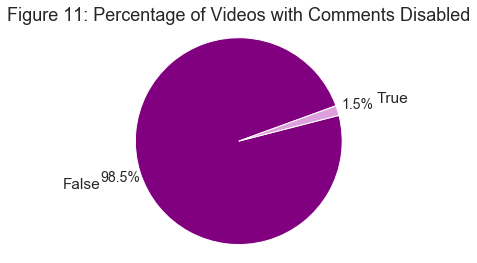

In [37]:
# Pie chart for Comments Disabled
fig, ax = plt.subplots()
plt.rcParams['font.size']=14

plt.pie(comments_disabled, labels=comments_disabled.index, 
        autopct='%1.1f%%', startangle=20,
        pctdistance=1.2,labeldistance=1.4,
        colors = ['purple', 'plum'])
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
plt.title("Figure 11: Percentage of Videos with Comments Disabled", fontsize=18)
plt.axis('equal')
plt.tight_layout()
plt.show()

- Comments Disabled: 633 videos
- Comments Active: 40,316 videos

The majority of videos leave their commenting properties on with only 1.5% of videos with commenting turned off.

### **Statistics for Disabled Ratings**

In [38]:
ratings_disabled = df['ratings_disabled'].value_counts()

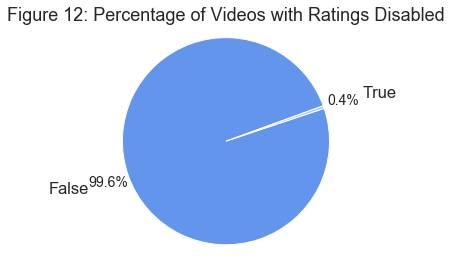

In [39]:
# Pie chart for Ratings Disabled
plt.rcParams['font.size']=14

plt.pie(ratings_disabled, labels=ratings_disabled.index, 
        autopct='%1.1f%%', startangle=20,
        pctdistance=1.2,labeldistance=1.4,
        colors = ['cornflowerblue', 'lightsteelblue'])
sns.set(font_scale=1.5)
plt.title("Figure 12: Percentage of Videos with Ratings Disabled", fontsize=18)
plt.axis('equal')
plt.tight_layout()
plt.show()

- Ratings Disabled: 169 videos
- Ratings Active: 40,780 videos

### **Data Cleaning After Exploration** 
We will drop all videos that have comments disabled, ratings (likes and dislikes) disabled, or video error or removed for our analysis portion as we cannot measure the videos level of engagement without these pieces of information.  Furthermore, less than 2% of videos, seen in Figures 11 and 12, have these features disabled, so these videos are some outliers in our data, which we don't want to use in our analysis.

In [40]:
df.drop(df[(df['comments_disabled'] == True) | (df['ratings_disabled'] == True) | (df['video_error_or_removed'] == True)].index, inplace=True)
df.drop(df[(df['likes'] == 0) & (df['dislikes'] == 0) & (df['comment_count'] == 0)].index, inplace=True)
df.drop(columns=['comments_disabled', 'ratings_disabled', 'video_error_or_removed'], errors='ignore',inplace=True)

# **Data Analysis and Results**
## **Analysis 1: Dislike - Engagement Correlation**
During our data visualization, we observed that the majority of trending YouTube videos have their ratings (like and dislike button) and comments active, with a small sliver of videos with them disabled. This seems odd as one would predict that engagement through ratings and comments would help increase video views by keeping the video in the limelight. Maybe creators disable these features to keep out dislikes and potentially negative comments, but what if getting dislikes increases a video's engagement, thus increasing its "popularity".  This is what we will try to figure out in our first analysis.

> **Research Question**: Do more dislikes indicate a higher engagement rate (dislike ratio or dislikes rate -> or comment rate)? Can this be extended to a specific category?
>
>**Hypothesis**: More dislikes will be correlated with a greater comment rate.  We predict that this will be particuarly strong in the News & Politics category, more so than in other categories.

In [41]:
# Using df_1 for Analysis 1
df_1 = df.copy()

### **Dislike & Engagement Measurement**
For our analysis of dislikes, we will look at both the **dislike rate**, which refers to the amount of dislikes compared to the total number of video views, and the **dislike ratio**, which refers to the amount of dislikes compared to the total number of ratings (likes + dislikes). And our operational definition for engagement rate will be in the form of **comment rate**, which refers to the amount of comments compared to the total number of video views.

In [42]:
# Create converted rates/ratio columns
df_1['comment_rate'] = df_1['comment_count'] / df_1['views']
df_1['dislike_rate'] =  df_1 ['dislikes'] / df_1['views']
df_1['dislike_ratio'] = df_1['dislikes'] / (df_1['dislikes'] + df_1['likes'])

### **Distribution Visualization**
Now we will plot the distribution for the comment rate, dislike rate, and dislike ratio to get a feeling for the shape of the distribution

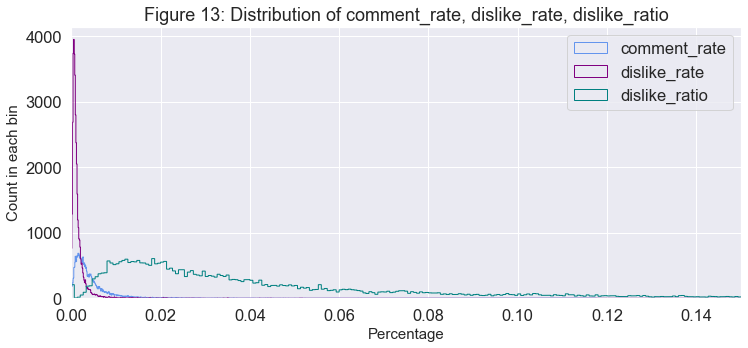

In [43]:
# Plot distribution of comment rate, dislike rate, and dislike ratio
plt.figure(figsize=(12,5))
plt.hist(df_1['comment_rate'],label='comment_rate',bins=1500,
         color='cornflowerblue', histtype='step')
plt.hist(df_1['dislike_rate'],label='dislike_rate',bins=1500,
         color ='purple', histtype='step')
plt.hist(df_1['dislike_ratio'],label='dislike_ratio',bins=1500,
         color='teal', histtype='step')
plt.title("Figure 13: Distribution of comment_rate, dislike_rate, dislike_ratio", 
         fontsize=18)
sns.set(font_scale=1.5)
plt.xlabel("Percentage", fontsize=15)
plt.ylabel("Count in each bin", fontsize=15)
plt.xlim(0,0.15)
plt.legend()
plt.show()

From Figure 13, we observe that the majority of trending videos have both *low* dislike rates and *low* comment rates. And we can see that the shape of these two distributions are similar (both right skewed).  Now that we have observed the distributions, we will now look for relationships between dislikes and comments.  When people dislike a video, do they tend to dissent publicly by leaving a comment, thus increasing a video's engagment?

### **Number of Dislikes - Number of Comments**
First we will consider the relationship between the number of dislikes and the number comments, which we will do by creating a scatter plot.  In Figure 14, we observe that most of the data points cluster near the origin with multiple near-linear lines stemming from this cluster.  Although we can see a positive correlation between these two variables, it is not in a linear manner, thus this could not be fitted well by a single line, so we need to consider more variables.

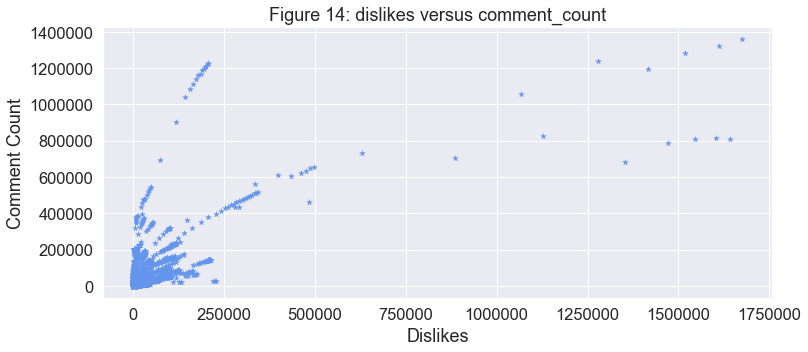

In [44]:
plt.figure(figsize=(12,5))
plt.scatter(df_1['dislikes'],df_1['comment_count'],marker='*',
            linewidths=0.3, color='cornflowerblue')
plt.title("Figure 14: dislikes versus comment_count")
plt.xlabel("Dislikes")
plt.ylabel("Comment Count")
plt.show()

### **Dislike Rate - Comment Rate**
Now we will consider the relationship between dislike rate and comment rate, as we feel that factoring in views is important for our analysis since the number of views is a major factor for measuring public exposure.  In Figure 15, we have a scatter plot with computed data-normalized points with a variable range of [0,1].  There is a cluster of data points at the origin, but there doesn't seem to be a strong correlation between the variables, so we will continue to explore different relationships.

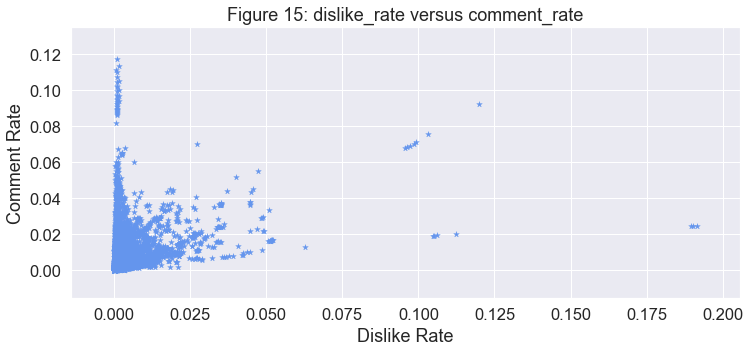

In [45]:
plt.figure(figsize=(12,5))
plt.scatter(df_1['dislike_rate'],df_1['comment_rate'],marker='*',linewidths=0.3, 
           color='cornflowerblue')
plt.title("Figure 15: dislike_rate versus comment_rate")
plt.xlabel("Dislike Rate")
plt.ylabel("Comment Rate")
plt.show()

### **Dislike Ratio - Comment Rate**
Now we will factor in likes to measure the controversialness of videos.  We operationalize controversy as the number of dislikes being greater than or equal to the number of likes.  Intuitively, we thought that greater controversy for a video would lead to higher comment rate.  However, in Figure 15, we observe that a considerable amount of videos have an overwhelming number of dislikes with comment rates of nearly 0.  Since this distribution still does not suggest a linear relation, we will keep massaging the data by adding more information.

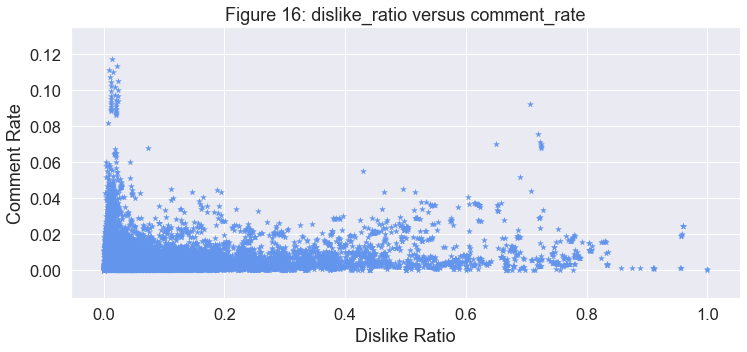

In [46]:
plt.figure(figsize=(12,5))
plt.scatter(df_1['dislike_ratio'],df_1['comment_rate'],marker='*',linewidths=0.3, 
           color='cornflowerblue')
plt.title("Figure 16: dislike_ratio versus comment_rate")
plt.xlabel("Dislike Ratio")
plt.ylabel("Comment Rate")
plt.show()

### **Controversy Index**
Wanting to keep exploring the idea of controversy, we will define a **controversy index**, which refers to amount of controversial videos that a category has.  We will define a category with the average number of videos having *high* like rate and *low* comment rate as having a low controversy index, while a category with the average number of videos having *high* dislike rate and a *high* comment rate as having a high controversy index.

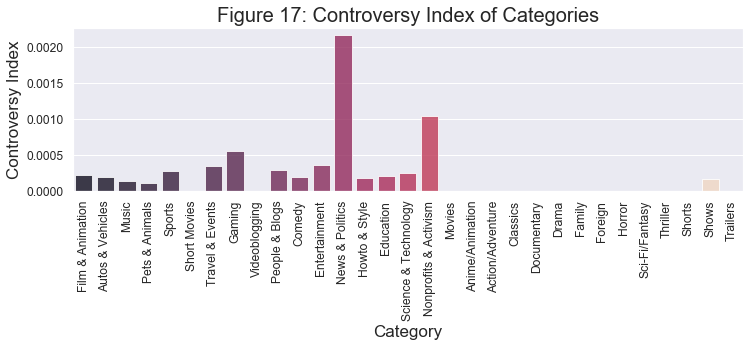

In [47]:
# Finding the controversy index for each category
df_1['pd_cr_dr'] = df_1['comment_rate']*df_1['dislike_ratio']
v_pcd, l_pcd = [],[]
for i,c in ID_to_Category.items():
    l_pcd.append(c)
    pcd = list(df_1[df_1['category_id']== c]['pd_cr_dr'])
    if len(pcd) > 0: v_pcd.append(np.mean(pcd))
    else: v_pcd.append(0)
sns.set_style("darkgrid")
sns.set(font_scale=1.1)
# Bar graph for the controversy index for each category
fig= plt.figure(figsize=(12,3))
plt.xticks(rotation=90)
sns.barplot(l_pcd, v_pcd, alpha=0.8, palette="rocket")
#plt.bar(range(len(v_pcd)),v_pcd,tick_label = l_pcd)
plt.xlabel('Category', fontsize=17)
plt.ylabel('Controversy Index', fontsize=17)
plt.title('Figure 17: Controversy Index of Categories', fontsize=20)
plt.show()

From Figure 17, we observe a very high controversy index for the **News & Politics** category followed by a high controversy index for the **Nonprofits & Activism** category. The rest of the categories have relatively similar with low controversy indices.  This suggests that people are more likely to dislike and leave comments on videos considering politics and social issues, which makes sense as people tend to have strong personal opinions and beliefs on these sensitive topics.

### **Dislike Ratio - Comment Rate for News & Politics**
Now knowing that there is a high controversy index for the News & Politics category, we will only look at the videos in this category as we want to see if controversialness (greater dislikes) increases engagement (comment rate).  Now we will train a linear model to demonstrate the correlation between dislike ratio and comment rate for videos in the News & Politics category.

In [48]:
# Defining a linear model wrapper for convenient training.
def linear_model(x_str, y_str, df):
    # Inputs:
    #      x_str - name of the column in df that represents x
    #      y_str - name of the column in df that represents y
    #      df - target dataframe
    # Output:
    #      res - sm.regression.linear_model.RegressionResultsWrapper
    outcome, predictor = patsy.dmatrices('{0} ~ {1}'.format(y_str,x_str), df)
    model = sm.OLS(outcome, predictor)
    return model.fit()

In [49]:
res_dislike_ratio_comment_rate_news = linear_model('dislike_ratio','comment_rate',df_1[df_1['category_id']=='News & Politics'])
print (res_dislike_ratio_comment_rate_news.summary())

                            OLS Regression Results                            
Dep. Variable:           comment_rate   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     829.5
Date:                Fri, 17 Jan 2020   Prob (F-statistic):          3.99e-156
Time:                        17:08:52   Log-Likelihood:                 8468.4
No. Observations:                2313   AIC:                        -1.693e+04
Df Residuals:                    2311   BIC:                        -1.692e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0028      0.000     14.373

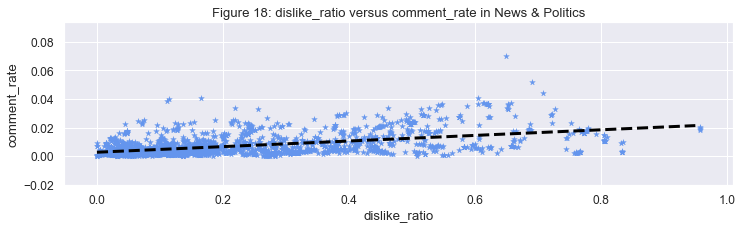

In [50]:
fig= plt.figure(figsize=(12,3))
plt.scatter(df_1[df_1['category_id']=='News & Politics']['dislike_ratio'],
            df_1[df_1['category_id']=='News & Politics']['comment_rate'], 
            marker='*', color='cornflowerblue',
            linewidths=0.3)
xs = np.arange(df_1[df_1['category_id']=='News & Politics']['dislike_ratio'].min(),
               df_1[df_1['category_id']=='News & Politics']['dislike_ratio'].max(),
               step=0.01)
ys = 0.0196*xs+0.0028
plt.plot(xs,ys,'--k', linewidth=3,color='black')
plt.title("Figure 18: dislike_ratio versus comment_rate in News & Politics")
plt.xlabel("dislike_ratio")
plt.ylabel("comment_rate")
plt.show()

### **Results**
> For the scope of the whole dataset, we did not find that more dislikes led to higher engagement rate.  We found that the majority of videos have *low* dislike rate and *low* comment rate, which clustered near the origin after data normalization.

> After finding our hypothesis invalid for the scope of the whole dataset, we still wanted to explore this idea of dislikes leading to higher engagement, which is why we removed noise by looking at controversy index.  By picking the category with the greatest controversy index (News & Politics), we were able to select a subset of the data with controversial videos to test if more dislikes indicated higher engagement, which it did.  In the News & Politics category, we found that more dislikes did lead to higher engagement rate.

##  **Analysis 2: Title Keywords**
At the beginning of our data exploration we looked at the 50 most common words that appeared in the tiles of trending YouTube videos.  The distribution of words was right skewed with words like "trailer", "official", and "new" occuring a lot more than the other most common words.  These words seem to be related to the Entertainment category (with the most number of trending videos) such that people include these words when uploading movies and shows.  Since the title of the video is one of the first pieces of information you get from a video, we want to explore if using certain words will increase a video's number of views.

After that, we perform a case study on sports category to study how keywords and combinations of keywords affect the popularity of videos.

> **Research Question**: Under sports category, what kind of keywords in the title increase the number of views?
>
> **Hypothesis**: If the video title has high frequency keywords like 'hightlights', 'nba', and 'nfl', the video in sports cateogry gets much more views than those who do not.

In [51]:
# Using df_2 for Analysis 2
df_2 = df.copy()

### **Most Common Words for Categories**
Since we want to figure out if certain words increase a video's views, we need to look at the most common words like we did during our visualization.  However, we need to look at the most common words for each category, as certain categories are likely to use certain words more than others. To make these observations, we will create a function that first finds the most common words in a specific category and then plots a bar graph of these most common words to help us visualize.

In [52]:
def top_k_words_of_category(category, figure_name, k=5):
    # Inputs:
    #      category - target category
    #      k - number of top words wanted
    # Output:
    #      plot of the k top words for the category
    df_c = df_2[df_2['category_id'] == category]
    cnt_c = Counter()
    for title in df_c['title_cl']:
        for token in title.split():
            cnt_c[token] += 1

    dist_c = cnt_c.most_common(k)
    top_words_c = []
    freqs_c = []
    for word, freq in dist_c:
        top_words_c.append(word)
        freqs_c.append(freq)

    fig= plt.figure(figsize=(8,6))
    plt.xticks(rotation=90)
    plt.bar(top_words_c, freqs_c, color='skyblue')
    plt.title(figure_name, fontsize=20)
    plt.xlabel('Keyword', fontsize=17)
    plt.ylabel('# Video Titles', fontsize=17)


We will first look at the top 10 words for the **Entertainment** and **Music** categories as they are categories with the most trending videos.

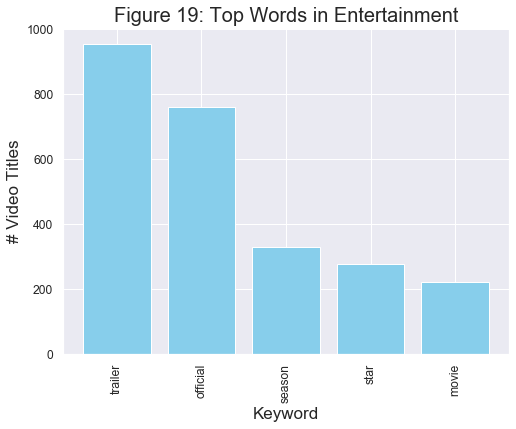

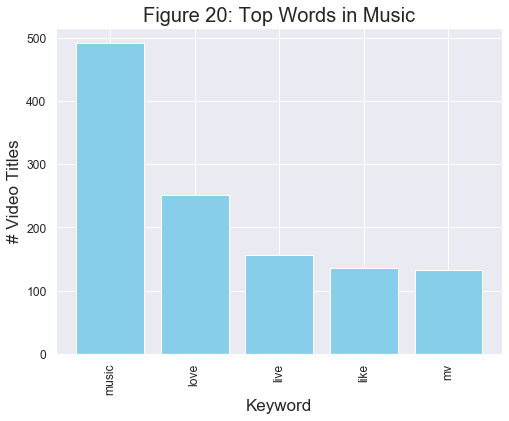

In [53]:
top_k_words_of_category('Entertainment', 'Figure 19: Top Words in Entertainment')
top_k_words_of_category('Music', 'Figure 20: Top Words in Music')

Both distributions are skewed, as seen in Figures 19 and 20, with titles in the **Entertainment** category heavily using the words "trailer" and "official" and titles in the **Music** category heavily using the words "music" and "love".  These frequently used words make sense as people like to watch the "Official Trailer" of new movies and a lot of today's music is about love.

The next category we will look at is **Sports**, since the channel with the most trending videos, EPSN, is a sports channel.  In Figure 21 shown below, we see that the words "highlights", "game", "espn", "nba", and "nfl" are the 5 most frequently used words in the video titles for the sport's category.  The most occuring word is "highlights" which makes sense as people like to watch game highlights to get a recap of what happened.  We also see that "nba" and "nfl" appear frequently, which suggests that people have a preference for watching basketball and football videos.

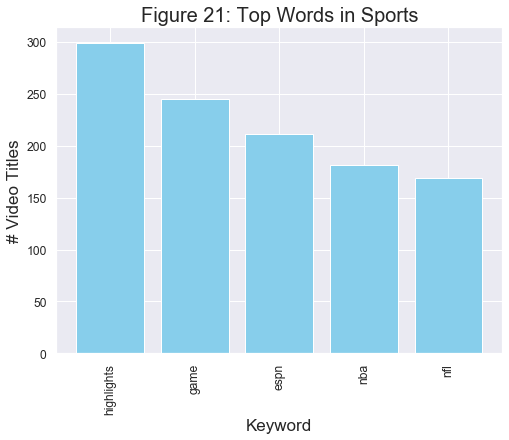

In [54]:
top_k_words_of_category('Sports', 'Figure 21: Top Words in Sports')

### **Sports Case Study**
We want to examine two cases: (1) Titles with one of the keywords, and (2) Titles with multiple keywords
    
We will first create a function that allows us to examine these two cases.  The function we define below returns the distribution of views for a particular category given a set of keywords that the title must include and a set of words that must be excluded from the title.  For example, if we use the keyword "highlights" and exclude the words "nba" and "nfl" for *Sports* videos, the function will return the distribution of all video views from the Sport's category that contain "highlights" in their title and not the words "nba" and/or "nfl".

In [55]:
def views_dist_exclude(keywords, excl, category):
    # Inputs:
    #      keywords - word(s) the title must include
    #      excl - word(s) the title must exclude
    #      category - from which the titles are from
    # Output:
    #      dist - distribution of views that include the keyword in the title
    #             and not the excluded words
    dist = []
    df_cate = df_2[df_2['category_id'] == category]
    for _, row in df_cate.iterrows():
        title_tokens = set(row['title_cl'].split())
        if excl.issubset(title_tokens):
            continue
        if keywords.issubset(title_tokens):
            dist.append(row['views'])
    return dist

### **View Distribution for Highlights, NBA, and NFL**
In Figure 21, we found the most common words and now we will find the view distribution for three of them: "highlights", "nba", and "nfl".  We have chosen not to look at the view distribution for "game" as that word is used in more than just Sports category, such as the Gaming category.  We will also not look at the one for "epsn" as that is the name of a specific channel and we want to observe more general words.

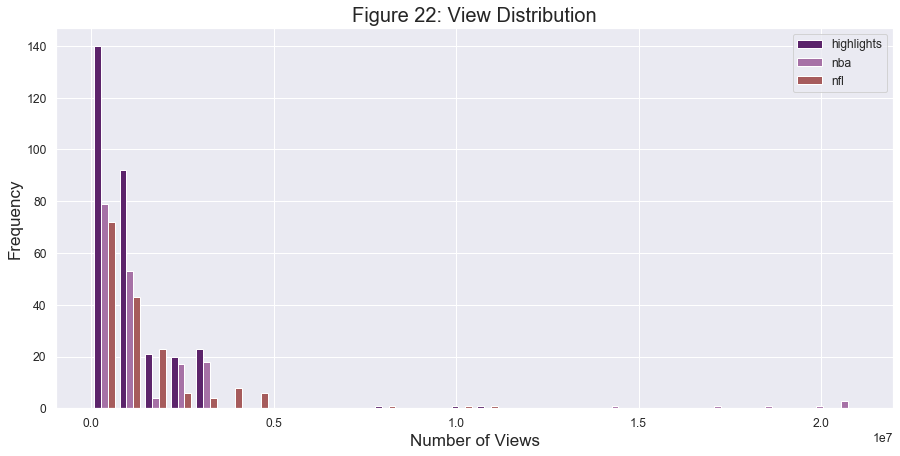

In [56]:
# View distribution for titles with the keyword in the Sports category
dist_hl = views_dist_exclude({'highlights'}, {'nba', 'nfl'}, 'Sports')
dist_nba = views_dist_exclude({'nba'}, {'highlights', 'nfl'}, 'Sports')
dist_nfl = views_dist_exclude({'nfl'}, {'highlights', 'nba'}, 'Sports')

# Histogram for the view distribution for highlights, nba, and nfl
fig= plt.figure(figsize=(15,7))
plt.hist([dist_hl, dist_nba, dist_nfl], label=['highlights', 'nba', 'nfl'], 
         color = ['#5c246b', '#a671a6', '#a65b5c'], bins=30)
plt.legend(loc='upper right')
plt.title('Figure 22: View Distribution', fontsize=20)
plt.xlabel('Number of Views', fontsize=17)
plt.ylabel('Frequency', fontsize=17)
plt.show()

From Figure 22, we observe that the distribution for all three cases are strongly right-skewed.  We also see that the nba view distribution (distribution of video views from titles with the word "nba" and not "highlights" and/or "nfl") has the longest tail, which means that there are some nba videos that have a many more views.

### **Looking at the Means**
Since our histogram (Figure 22) was strongly skewed, we will compare the average views for our three distributions and the entire sports category to further look at the impact of certain keywords on the number of views for videos in the Sports category.

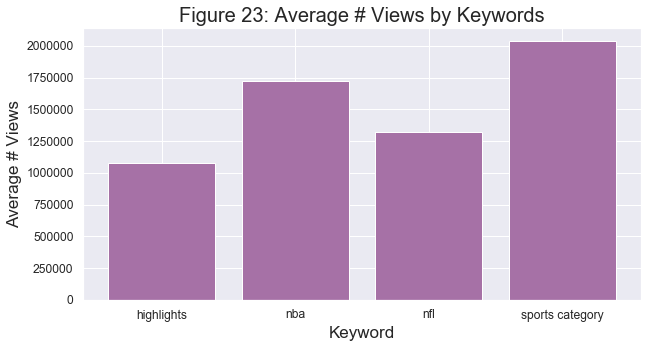

In [57]:
# Calculating the mean number of views for each distribution
cnt_hl = np.mean(dist_hl)
cnt_nba = np.mean(dist_nba)
cnt_nfl = np.mean(dist_nfl)
avg = df_2[df_2['category_id'] == 'Sports']['views'].mean()
cnt_view = [cnt_hl, cnt_nba, cnt_nfl, avg]

# Bar graph for the average number of views for each distribution
fig= plt.figure(figsize=(10,5))
plt.title('Figure 23: Average # Views by Keywords', fontsize=20)
plt.xlabel('Keyword', fontsize=17)
plt.ylabel('Average # Views', fontsize=17)
plt.bar(['highlights', 'nba', 'nfl', 'sports category'], height=cnt_view, color='#a671a6')
plt.show()

In Figure 23, we observe that average number views for the entire distribution of sports videos is the greatest.  This seems to go against our hypothesis, but it may be due to the fact that the entire sports category includes a lot more videos than our 3 smaller distributions.  So it may be that the distribution for the entire sports category includes more outlier videos with a large number of views to pull the average up.

Taking all this information into account, we now ask if these keywords have correlation? As in do videos with titles containing a combination of these keywords get more views?  To analyze this, we will create two more distributions:
- **"nba highlights"**: distribution of views for videos with title's including "highlights" and "nba" and excluding "nfl" in the Sports category
- **"nfl highlights"**: distribution of views for videos with title's including "highlights" and "nfl" and excluding "nba" in the Sports category

### **View Distribution for NBA Highlights and NFL Highlights**

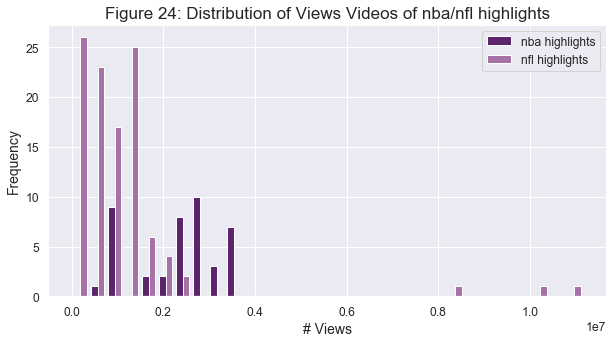

In [58]:
# Create distribution for nba highlights and nfl highlights
dist_hnba = views_dist_exclude({'highlights', 'nba'}, {'nfl'}, 'Sports')
dist_hnfl = views_dist_exclude({'highlights', 'nfl'}, {'nba'}, 'Sports')

# Create histogram
plt.figure(figsize=(10,5))
plt.hist([dist_hnba, dist_hnfl], label=['nba highlights', 'nfl highlights'], 
         bins=30, color = ['#5c246b', '#a671a6'])
plt.legend(loc='upper right')
plt.title('Figure 24: Distribution of Views Videos of nba/nfl highlights', fontsize=17)
plt.xlabel('# Views', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

The above histogram (Figure 24) shows us that the distribution of views for 'nba highlights' has a clear right shift compared to that of titles that contains 'nba' only, and there are almost no tails, unlike the tails we found in Figure 22.

### **Looking at the Means (Again)**

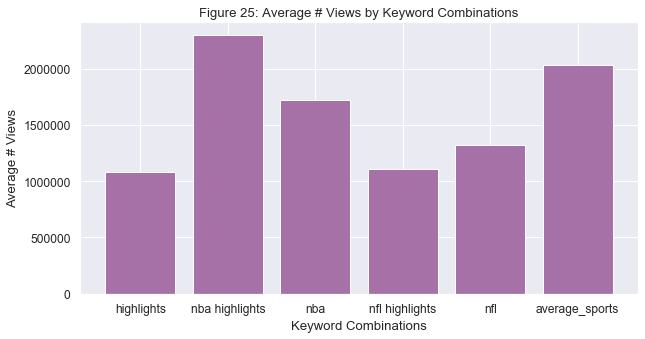

In [59]:
# Calculate the means
cnt_hnba = np.mean(dist_hnba)
cnt_hnfl = np.mean(dist_hnfl)
cnt_hview = [cnt_hl, cnt_hnba, cnt_nba, cnt_hnfl, cnt_nfl, avg]

# Create the bar graph
fig= plt.figure(figsize=(10,5))
plt.title('Figure 25: Average # Views by Keyword Combinations')
plt.xlabel('Keyword Combinations')
plt.ylabel('Average # Views')
plt.bar(['highlights', 'nba highlights', 'nba', 'nfl highlights', 'nfl', 'average_sports'], 
        height=cnt_hview, color ='#a671a6')
plt.show()

In Figure 25, we observe that the average views for "nba highlights" now tops the average views for the entire sports category by about 200,000.  On the other hand, "nfl highlights" has around the same average as the "highlights" distribution.  Overall, this graph suggests that people like to watch basketball videos, with both videos with titles including "nba highlights" and "nba" having high averages.

### **Results**
> There is a correlation between some title keywords and number of views of video, but the hypothesis is not true since multiple keywords can be involved instead of a single one. Also, Figure 25 shows that a combination of top keywords does not necesearily increase the number of views; the impact of keywords combination really depends on the content.

# **Privacy/Ethics Consideration**

This Trending Youtube Video Statistics dataset is a public dataset from Kaggle built using Youtube’s API Services. Developers have permission to use data collected from Youtube’s API Services as long as they follow the policies listed in the Youtube API Services Policies document. Overall, online video research does raise valid ethical and data privacy concerns regarding informed consent. However, the unique potential of such a dataset outweighs the cost since this report is not for a commercial purpose  And in our analysis, we have minimized the use of unique identifiers of the Youtube Video by using a bag-of-word model to analyze common terms in the title, tags, and description.

# **Conclusions and Discussion**

We do find a positive correlation between controversialness of a video and viewer engagement in categories concerning politics and social issues. However, there are limitations of this project due to the incompleteness of dataset, confounding variables in real world scenario, and assumptions to simplify a complicated problem. We will handle this potential issue by recognizing the impact of the bias in the conclusion and discussion of our results.

As for keywords in video titles. Although we found that there are some correlations between keywords and the number of views, the impact is not completely cliear. We observed that in some category some words dominate the context of video title, but videos whose title contains some of those top words does not neccearily become more popular than those who do not.

Since the Trending Youtube Video dataset includes only top trending videos, there is a potential for survivor bias in the results. Videos with similar characteristics, that did not trend, are not included in the dataset and thus will not be studied.

We assume that video statistics such as views are independent of category, title, and many other variables presented in this dataset. Each view count is assumed to have equal weights. However, we do not consider the replayability of a video because it cannot be distinguished from the dataset. In addition, we assume that there is no underlying association between individual ratings of a video. However, ratings in this dataset can inaccurately reflect the hidden distribution as comment and rating bots might be involved.

For convenience, we assume that frequent words in each category has higher impact on the number of views. However, some less frequent words that appear in only a few videos might also have great impact (by the assumption of tf-idf). In our study, we only focus on more general cases that covers the majority videos of the category.

Regarding future work, our group will try more advanced techniques on video statistics analysis, such as regression models and learning algorithms. We will also employ more language models in the realm of Natural Language Processing, such as word2vec, topic models and tf-idf. Besides working on numerical and string-based data, we will extend this analysis to image data by encoding thumbnails. As for content-based analysis, we cound obtained news paper headlines from other dataset or using topic model to study the effect of trending news on trending videos.